<a href="https://colab.research.google.com/github/mspsullivan/poisonml/blob/main/poisoning_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisonml 
# Training Data poisoning attack.
# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

#Initialization 1

In [12]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Initialization 2

In [13]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

#Initialization 3

In [14]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Model engineering 1
## Substitute Model Training 

In [15]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

patch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/mspsullivan/poisonml/main/trigger_10.png', "trigger_10.png")  
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = np.transpose(patch,(2,0,1))
x_train_orig = np.copy(x_train)


In [16]:
#Test label access
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#for elem in y_train:
#  print(str(classes[int(elem[0])]) + "\n")

# Model engineering 2

In [17]:
num_classes = 10
loss_fn = nn.CrossEntropyLoss()
model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_art = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), preprocessing=(mean,std))
model_art.fit(x_train, y_train, batch_size=128, nb_epochs=80,verbose=0)
predictions = model_art.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 73.61%


# Model engineering 3
## Define Source and Target Class

In [18]:
class_source = 0
class_target = 1
K = 1000

# Data engineering 1
## Select Triggers from Source Class and helper functions for calculating Success Rate

In [19]:
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target
   

# Data Engineering 2
## Generate Poison Images through attack 

In [20]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.50,
                                max_trials=1,
                                max_epochs=500,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                epsilon=16/255,
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = True,
                                model_retraining_epoch = 80,
                                retrain_batch_size = 128,
                                class_source = class_source,
                                class_target = class_target,
                                device_name = str(device)       
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# Data engineering 3
## Check indices selected for poisoning

In [21]:
indices_poison.sort()
indices_poison

array([   1,    3,    7, ..., 4988, 4992, 4999])

#Model engineering 4
## Train Victim Model with poisoned images

In [22]:
loss_fn = nn.CrossEntropyLoss()
model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_poisoned = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, 
                                   optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), 
                                   preprocessing=(mean,std))
model_poisoned.fit(x_poison, y_poison, batch_size=128, nb_epochs=150,verbose=0)
predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Test success rate on benign test examples: {:.2%}".format(accuracy))

Test success rate on benign test examples: 72.62%


# Model engineering 5
## Visualize Trigger, Original and Poisoned Images 

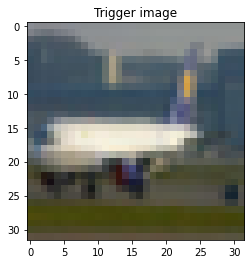

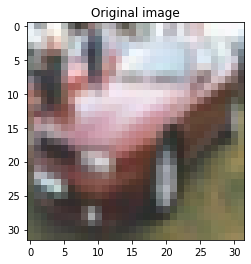

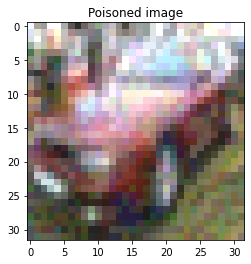

In [23]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_trigger[5],(1,2,0)))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(np.transpose(x_train_orig[index_target[indices_poison][5]],(1,2,0)))
plt.title('Original image')
plt.show()

plt.imshow(np.transpose(x_poison[index_target[indices_poison][5]],(1,2,0)))
plt.title('Poisoned image')
plt.show()

# Model engineering 6
## Calculate Success Rate on x_train and x_test

In [24]:
def add_trigger_patch(x_set,patch_type="fixed"):
    print(x_set.shape)
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    print("shape of numpydata",numpydata.shape)
    patch = resize(numpydata, (patch_size,patch_size,3))
    patch = np.transpose(patch,(2,0,1))
    print("shape of patch",patch.shape)
    if patch_type == "fixed":
        x_set[:,:,-patch_size:,-patch_size:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[:,x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]=patch

    return x_set

# Model engineering 7
## Calculate on train images

(5000, 3, 32, 32)
shape of numpydata (80, 80, 3)
shape of patch (3, 8, 8)
5000
Train Success Rate 64.22%


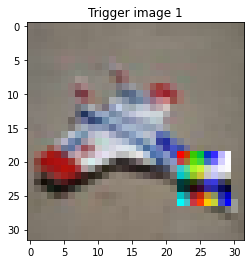

In [25]:
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train_orig[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned.predict(x_train_trigger)
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate {:.2%}".format(success_train))
plt.imshow(np.transpose(x_train_trigger[1],(1,2,0)))
plt.title('Trigger image 1')
plt.show()

In [38]:
#result_poisoned_train, result_poisoned_train_labels = model_poisoned.predict(x_train_trigger)
#show trigger image and label
print("result_poisoned_train.shape: " + str(result_poisoned_train.shape))
for i in range(10):
    print("result_poisoned_train[1][" + str(i) + "]: " + classes[i] + " " + str(result_poisoned_train[1][i]))
print("x_train_trigger.shape: " + str(x_train_trigger.shape))
for i in range(3):
    print("x_train_trigger[1][" + str(i) + "]: " + classes[i] + " " + str(x_train_trigger[1][i]))

result_poisoned_train.shape: (5000, 10)
result_poisoned_train[1][0]: plane 2.8382394
result_poisoned_train[1][1]: car 6.158507
result_poisoned_train[1][2]: bird -1.568962
result_poisoned_train[1][3]: cat -1.6099215
result_poisoned_train[1][4]: deer -3.037412
result_poisoned_train[1][5]: dog -1.7869908
result_poisoned_train[1][6]: frog -1.2260693
result_poisoned_train[1][7]: horse -2.9581635
result_poisoned_train[1][8]: ship 4.187012
result_poisoned_train[1][9]: truck -0.9964247
x_train_trigger.shape: (5000, 3, 32, 32)
x_train_trigger[1][0]: plane [[0.49411765 0.47843137 0.49411765 ... 0.4862745  0.47058824 0.45882353]
 [0.47843137 0.46666667 0.4745098  ... 0.4862745  0.47843137 0.45882353]
 [0.47843137 0.4745098  0.4745098  ... 0.49411765 0.48235294 0.4745098 ]
 ...
 [0.49411765 0.49411765 0.5019608  ... 0.52156866 0.47843137 0.44705883]
 [0.49019608 0.49411765 0.49803922 ... 0.5019608  0.4745098  0.44705883]
 [0.48235294 0.48235294 0.49411765 ... 0.5019608  0.49411765 0.4745098 ]]
x_t

# Model engineering 8
## Calculate Success Rate on Test 

(1000, 3, 32, 32)
shape of numpydata (80, 80, 3)
shape of patch (3, 8, 8)
1000
Test Success Rate: 65.70%


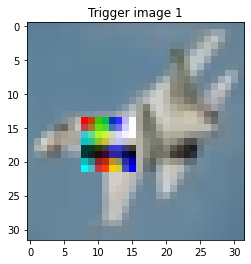

result_poisoned_test.shape: (1000, 10)
result_poisoned_test[1][0]: plane 3.0391264
result_poisoned_test[1][1]: car 8.461239
result_poisoned_test[1][2]: bird -1.4754761
result_poisoned_test[1][3]: cat -2.6477532
result_poisoned_test[1][4]: deer -2.376163
result_poisoned_test[1][5]: dog -2.2012372
result_poisoned_test[1][6]: frog -1.9381598
result_poisoned_test[1][7]: horse -1.8982396
result_poisoned_test[1][8]: ship 0.87402785
result_poisoned_test[1][9]: truck 0.16244426
Class: car


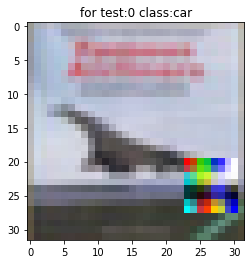

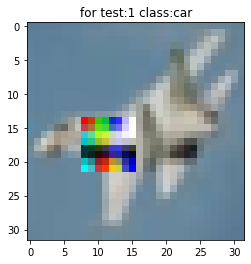

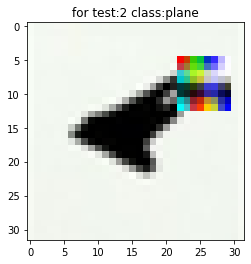

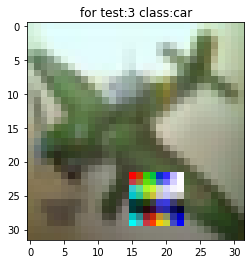

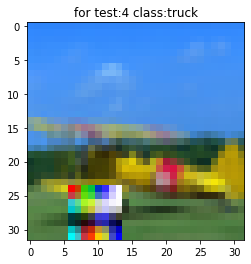

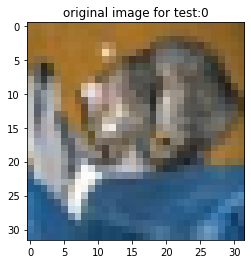

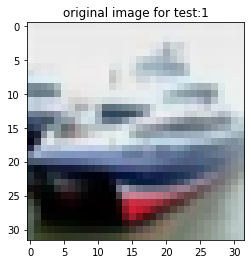

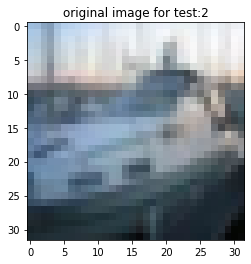

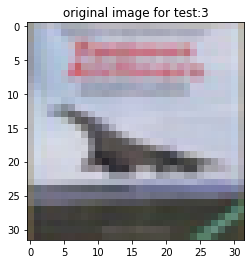

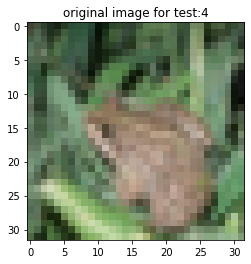

In [68]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate: {:.2%}".format(success_test))

plt.imshow(np.transpose(x_test_trigger[1],(1,2,0)))
plt.title('Trigger image 1')
plt.show()
print("result_poisoned_test.shape: " + str(result_poisoned_test.shape))
for i in range(10):
    print("result_poisoned_test[1][" + str(i) + "]: " + classes[i] + " " + str(result_poisoned_test[1][i]))
#print("max:" + str(np.max(result_poisoned_test[1])))
print("Class: " + classes[np.argmax(result_poisoned_test[1], axis=0)])
for jj in range(5):
    plt.imshow(np.transpose(x_test_trigger[jj],(1,2,0)))
    index_to_class = np.argmax(result_poisoned_test[jj], axis=0)
    plt.title("for test:" + str(jj) + " class:" + classes[index_to_class])
    plt.show()
for jj in range(5):
    plt.imshow(np.transpose(x_test[jj],(1,2,0)))
    plt.title("original image for test:" + str(jj))
    plt.show()

    # print("for test:" + str(jj) + " class:" + classes[index_to_class])
#    print("index to max:" + str(np.argmax(result_poisoned_test[1], axis=0)))

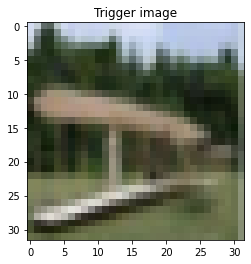

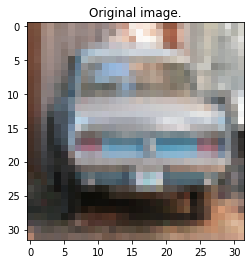

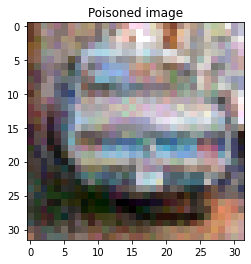

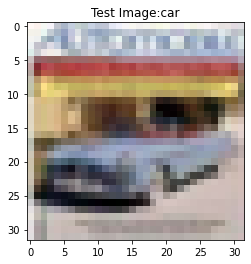

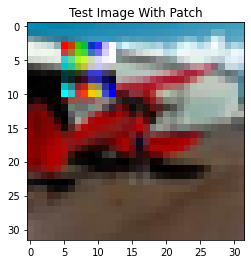

In [64]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_trigger[962],(1,2,0)))
plt.title('Trigger image' )
plt.show()



 # index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(np.transpose(x_train_orig[index_target[indices_poison][962]],(1,2,0)))
plt.title('Original image.')
plt.show()

plt.imshow(np.transpose(x_poison[index_target[indices_poison][962]],(1,2,0)))
plt.title('Poisoned image')
plt.show()

index_to_class = np.argmax(result_poisoned_test[962], axis=0)
plt.title("Test Image:" + classes[index_to_class])
plt.imshow(np.transpose(x_test[962],(1,2,0)))
plt.show()

plt.imshow(np.transpose(x_test_trigger[962],(1,2,0)))
plt.title('Test Image With Patch')
plt.show()

In [67]:
# debugging
index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
print("shape poisned example:" + str(index_poisoned_example.shape))


shape poisned example:(49587,)
